In [8]:
# Importing libraries
import json
import pandas as pd
from pprint import pprint
import pandas_datareader.data as pdr
import datetime as dt
import numpy as np
import plotly.offline as py

# DataFrame

In [2]:
'''
Developing a class Dataframe to build a Pandas
Dataframe around the scraped data regarding
the cryptocurrency passed as input from the 
user.The script uses yahoo as the source of
information.The information once scraped 
from yahoo is then turned into a DF which is
further utilised for training,anlysis and 
training purposes.

All Prices are the cost
to purchase the minimum allowed quantity
on exchange. So the price of BTC means
price of buying minimum allowed QTY of BTC
on Exchanges like Binance that is 0.0001


Class has following attributes :
        crypto_name : name of crypto asset
        start_date  : Initial Date of record
        end_date    : Last Date of record
        
Class has following functionalities:
        construct_df : returns the constructed DF
'''

class Dataframe:
    # Class Initialisation
    def __init__(self,crypto_name,start_date,end_date):
        self.crypto_name=crypto_name # Initialising the attributes
        self.start_date=start_date
        self.end_date=end_date
    
    
    # Class function
    def contruct_df(self):
        df = pdr.DataReader(self.crypto_name,'yahoo',start,end)
        return df

# Graphs

In [3]:
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plot
import plotly.express as px

'''
Developing a class plots to be used to plot
various Graphs based on our DF which will be
useful for analysing our underlying asset and
predict what its future might hold.This class
produces graphs for sole purpose of analysis.

Class has following attributes :
        df : Dataframe being used for drawing
             graphs.
        
Class has following functionalities:
        candle_stick    : Produces a candle stick graph
        
        volume_chart    : Produces a line chart showing
                          volume of the underlying asset.
                          
        sma             : Produces SMA chart for 20,50
        
        bollinger_bands : Produces the bollinger
                          bands graph of the asset

'''

class plots:
    def __init__(self,df): # Class Initialisation
        self.df=df
        
    def candle_stick(self):
        py.init_notebook_mode(connected=True) # TO ensure we can can see the graph here
        
        ######### Preparing Data For Graph ##############
        data = [go.Candlestick(x=self.df.index,
                               open=self.df.Open,
                               high=self.df.High,
                               low=self.df.Low,
                               close=self.df.Close)]
        #################################################
        
        # Fixing the Layout
        layout = go.Layout(title=f'{crypto_name.upper()} Candlestick with Range Slider',
                           xaxis={'rangeslider':{'visible':True}})
        
        
        # Plotting the figure
        fig = go.Figure(data=data,layout=layout)
        fig.update_layout(
        title = f'The Candlestick graph for {crypto_name}',
        xaxis_title = 'Date',
        yaxis_title = 'Price',
        xaxis_rangeslider_visible = False)
        fig.update_yaxes(tickprefix='$')
        py.iplot(fig,filename='f{crypto_name.upper()}_candlestick')
        xaxis = {'rangeselector':{'buttons':[{'count':1,
                                      'label':'1m',
                                      'step':'month',
                                      'stepmode':'backward'}]}}
        
    def volume_chart(self):
        fig = px.line(df,y="Volume", title=f'Trade Volume of {crypto_name.upper()}')
        fig.show()
    
    def sma(self):
        py.init_notebook_mode(connected=True)
        fig = go.Figure(
        data = [
            go.Candlestick(x=self.df.index,
                               open=self.df.Open,
                               high=self.df.High,
                               low=self.df.Low,
                               close=self.df.Close),
            go.Scatter(
                x = self.df.index, 
                y = self.df.Close.rolling(window=20).mean(),
                mode = 'lines', 
                name = '20SMA',
                line = {'color': '#ff006a'}
            ),
            go.Scatter(
                x = self.df.index, 
                y = self.df.Close.rolling(window=50).mean(),
                mode = 'lines', 
                name = '50SMA',
                line = {'color': '#1900ff'}
            )
        ])
        # Setting up the titles on X,Y and Main
        xn=''
        if crypto_name.lower()=='btc':
            xn='Index'
        else:
            xn='Date'
        fig.update_layout(
        title = f'The SMA graph for {crypto_name}',
        xaxis_title = xn,
        yaxis_title = 'Price',
        xaxis_rangeslider_visible = False)
        fig.update_yaxes(tickprefix='$')

        fig.show()
    
    def bollinger_bands(self):
        self.df['MA20'] = self.df.Close.rolling(window=20).mean() # Preparing Mean of Close column in DF
        self.df['20dSTD'] = self.df.Close.rolling(window=20).std() # Preparing Standard deviationg of Close column in DF

        self.df['Upper'] = self.df['MA20'] + (self.df['20dSTD'] * 2) # Calculating upper Bollinger Band
        self.df['Lower'] = self.df['MA20'] - (self.df['20dSTD'] * 2) # Calculating lower Bolling Band
        self.df[['Close','MA20','Upper','Lower']].plot(figsize=(10,4)) # Plotting only the calculated Columns
        
        # Setting up the graph
        plot.title(crypto_name + ' Bollinger Bands')
        plot.grid(True)
        plot.axis('tight')
        plot.ylabel('Price')
        plot.show()

# ML Model For Price Prediction

In [4]:
# Only pulling the Close Price for our model

def AI(df):
    price = df[['Close']]

    from sklearn.preprocessing import MinMaxScaler
    min_max_scaler = MinMaxScaler() # Initialising the MinMaxScaler

    norm_data = min_max_scaler.fit_transform(price.values) # Fitting our price columns values

    def univariate_data(dataset, start_index, end_index, history_size, target_size):

      '''
      This function is bassically useful for Reshaping our
      data for the model using Numpy
      '''

      data = []
      labels = []

      start_index = start_index + history_size
      if end_index is None:
        end_index = len(dataset) - target_size

      for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
      return(np.array(data), np.array(labels))

    past_history = 5
    future_target = 0

    '''

    In following lines we will be creating the Train and Test Data for our LSTM base Machine Learning Model.
    Train Data for training the Model and Test Data for testing accurancy of our model.This model will
    use it's training to understand patterns and implement it's understanding for predicting future price
    of the underlying asset.

    '''

    TRAIN_SPLIT = int(len(norm_data) * 0.8) # Splitting data in 80/20 with 80% going to training set

    # Creating the Training Dataset with univariate_data function
    x_train, y_train = univariate_data(norm_data,
                                       0,
                                       TRAIN_SPLIT,
                                       past_history,
                                       future_target)

    # Creating the Test Dataset 
    x_test, y_test = univariate_data(norm_data,
                                     TRAIN_SPLIT,
                                     None,
                                     past_history,
                                     future_target)
    
    from keras.models import Sequential
    from keras.optimizers import Adam
    from keras.layers import Dense, LSTM, LeakyReLU, Dropout

    ############# Model Details #############
    '''
    Model Type : Sequential
    Number of Layers : 64
    Learning Rate (Pace of Learning) : 0.0001
    Activation Function : Sigmoid
    Optimizer : Adam
    Loss Function : MSE
    Batch Size : 5 DataPoints
    Epochs : 100
    '''
    #########################################

    num_units = 64
    learning_rate = 0.0001
    activation_function = 'sigmoid'
    adam = Adam(lr=learning_rate)
    loss_function = 'mse'
    batch_size = 5
    num_epochs = 100

    # Initialize the RNN
    model = Sequential()
    model.add(LSTM(units = num_units, activation=activation_function, input_shape=(None, 1)))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.1))
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer=adam, loss=loss_function)
    
    # Passing the Data into our Model for training purpose
    history = model.fit(
        x_train,
        y_train,
        validation_split=0.1,
        batch_size=batch_size,
        epochs=num_epochs,
        shuffle=False
    )
    
    ######### Model Validation ############
    '''
    Here we will be plotting the Validation Loss 
    of the model to confirm improved performance 
    at every epoch.

    If our model preforms correctly then there 
    should be a downward trending graph for both
    Training Loss and Validation Loss.
    '''
    #######################################

    import matplotlib.pyplot as plt

    # Storing the historical data of the model in a list for plotting
    loss = history.history['loss'] 
    val_loss = history.history['val_loss']


    epochs = range(len(loss))# Creating a list of loss on every instance of epochs

    plt.figure() # Initialising the figure

    # Preparing the figure
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.show() # Plotting the Figure
    
    import seaborn as sns
    # Preparing a DF based out of Original values in Test Dataset
    original = pd.DataFrame(min_max_scaler.inverse_transform(y_test))

    # Preparing a DF based out of Predictions made by the ML Model
    predictions = pd.DataFrame(min_max_scaler.inverse_transform(model.predict(x_test)))
    
    # Plotting Line graph's based on original and Prediction Dataframes
    ax = sns.lineplot(x=original.index, y=original[0], label="Test Data", color='royalblue')
    ax = sns.lineplot(x=predictions.index, y=predictions[0], label="Prediction", color='tomato')

    # Setting up Labels
    ax.set_title(f'{crypto_name} price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (USD)", size = 14)
    ax.set_xticklabels('', size=10)
    plt.show()

# User Interface

Crypto Name : LTC
End Date (YYYY/MM/DD): 2021/05/19
Creating DataFrame For LTC
From : 2013/01/01 To : 2021/05/19
 
Greetings :)
Please select a option
1.Show Candlestick
2.Show Volume Traded
3.Show SMA20 and SMA50
4.Show Bollinger Bands
5.Predict
6.Exit
Your Input : 1


1.Show Candlestick
2.Show Volume Traded
3.Show SMA20 and SMA50
4.Show Bollinger Bands
5.Predict
6.Exit
Your Input : 2


1.Show Candlestick
2.Show Volume Traded
3.Show SMA20 and SMA50
4.Show Bollinger Bands
5.Predict
6.Exit
Your Input : 3


1.Show Candlestick
2.Show Volume Traded
3.Show SMA20 and SMA50
4.Show Bollinger Bands
5.Predict
6.Exit
Your Input : 4


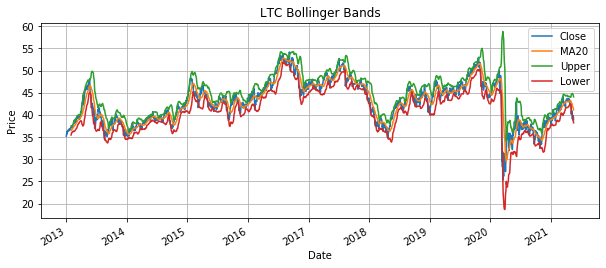

1.Show Candlestick
2.Show Volume Traded
3.Show SMA20 and SMA50
4.Show Bollinger Bands
5.Predict
6.Exit
Your Input : 5
Epoch 1/100
303/303 [==============================] - 2s 4ms/step - loss: 0.0939 - val_loss: 0.0229
Epoch 2/100
303/303 [==============================] - 1s 2ms/step - loss: 0.0440 - val_loss: 0.0193
Epoch 3/100
303/303 [==============================] - 1s 3ms/step - loss: 0.0378 - val_loss: 0.0186
Epoch 4/100
303/303 [==============================] - 1s 2ms/step - loss: 0.0409 - val_loss: 0.0230
Epoch 5/100
303/303 [==============================] - 1s 2ms/step - loss: 0.0356 - val_loss: 0.0220
Epoch 6/100
303/303 [==============================] - 1s 2ms/step - loss: 0.0323 - val_loss: 0.0162
Epoch 7/100
303/303 [==============================] - 1s 2ms/step - loss: 0.0335 - val_loss: 0.0233
Epoch 8/100
303/303 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0221
Epoch 9/100
303/303 [==============================] - 0s 2ms/step - loss:

303/303 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0055
Epoch 81/100
303/303 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0070
Epoch 82/100
303/303 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0058
Epoch 83/100
303/303 [==============================] - 1s 2ms/step - loss: 0.0069 - val_loss: 0.0054
Epoch 84/100
303/303 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0048
Epoch 85/100
303/303 [==============================] - 1s 2ms/step - loss: 0.0070 - val_loss: 0.0057
Epoch 86/100
303/303 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 87/100
303/303 [==============================] - 1s 2ms/step - loss: 0.0070 - val_loss: 0.0057
Epoch 88/100
303/303 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0051
Epoch 89/100
303/303 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 

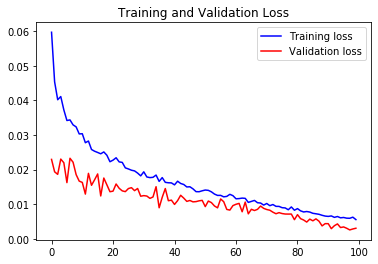

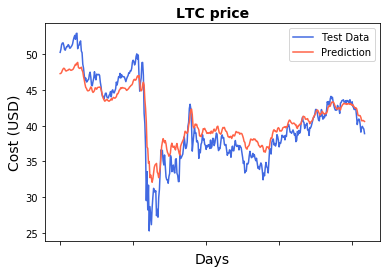

1.Show Candlestick
2.Show Volume Traded
3.Show SMA20 and SMA50
4.Show Bollinger Bands
5.Predict
6.Exit
Your Input : 6
Thank you and Goodbye :-)


In [9]:
######## User Input ###############################
crypto_name=str(input('Crypto Name : '))
start = '2013/01/01'
end = str(input('End Date (YYYY/MM/DD): '))
print(f'Creating DataFrame For {crypto_name.upper()}\nFrom : {start} To : {end}\n ')
##################################################

#Passing input variables into Dataframe Class
if crypto_name.lower()=='btc':
    df=pd.read_csv('btc_data.csv/btc_data_c.csv')
    df=df.dropna()
    df=df[:2000]
else:
    dfr=Dataframe(crypto_name,start,end) # Creating Class object
    df=dfr.contruct_df() # Calling Class function

plt_gr=plots(df)
print('Greetings :)\nPlease select a option')
while True:
    x=int(input('1.Show Candlestick\n2.Show Volume Traded\n3.Show SMA20 and SMA50\n4.Show Bollinger Bands\n5.Predict\n6.Exit\nYour Input : '))
    if x==1:
        plt_gr.candle_stick()
    elif x==2:
        plt_gr.volume_chart()
    elif x==3:
        plt_gr.sma()
    elif x==4:
        plt_gr.bollinger_bands()
    elif x==5:
        AI(df)
    elif x==6:
        print('Thank you and Goodbye :-)')
        break
    else:
        print('Invalid Input')